# Bridge Shoe Displacment Anomaly Detection using APCA

This code is for bridge shoe displacement anomaly detection using adaptive principle component analysis.
The shoe displacement is measured by circle detection-homography transfomation integrated method. 

In [1]:
import cv2 
import os 
import json
import csv
import io
import pickle
import os.path as osp
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

from datetime import datetime
from sscv import imwrite

from glob import glob 
from datetime import datetime
from pathlib import Path
from functools import partial
from p_tqdm import p_map
from tqdm import tqdm 

from module.utils import imread, imfindcircles 
from module.utils import circle_detection_multi_thread, find_valid_dest_circles, adjust_gamma
from module.utils import cvtClcToDict, saveCDResult, tmpListToDict, dirListToDict, getDirList, snsInfoToDict, cvtDataForAPCA, plotData
from module.disp_measure import homography_transformation, adaptiveThreshold_3ch
from module.apca import run_apca_cas 

In [2]:
# search imgs in subdirectories 
img_folder_list = []
for sns_num in tqdm(img_sns_list) : 
    img_list = glob(osp.join(data_root, sns_type, sns_num, '*', '*', '*'))
    
    filtered_list_by_year =  [item for item in img_list if int(item.split('/')[-3]) >= 2021]
#     filtered_list_by_month =  [item for item in filtered_list_by_year if int(item.split('/')[-2]) >= 9]
#     filtered_list_by_date =  [item for item in filtered_list_by_month if int(item.split('/')[-1]) >= 1]
    img_folder_list.append(filtered_list_by_year)
    
    

NameError: name 'img_sns_list' is not defined

In [ ]:
for date_folder in img_folder: 
    # folder names 
    log_folder = osp.join(date_folder, 'logs')

    log_folder_exits = Path(log_folder).exists()


    if log_folder_exits : 

        log_folders_by_time = glob(osp.join(log_folder, '*' ))

        if len(log_folders_by_time) > 1 :
            log_folders_by_time.sort()
            latest_log = log_folders_by_time[-1]

        else: 
            latest_log = log_folders_by_time[0]


        circles_pickle_filename = osp.join(latest_log, 'circle_detection_results.pickle')
        circle_detection_folder = osp.join(latest_log, 'circle_detection_result_images')
        circle_detection_list = glob(osp.join(circle_detection_folder, "*.jpg"))

        with open(circles_pickle_filename , 'rb') as readfile:
            circles_dict = pickle.load(readfile)

        displacement_dict = dict()

        for circle_detection_image in circle_detection_list:
            image_basename = osp.basename(circle_detection_image)

            dest_circles = circles_dict[image_basename]

            if str(type(dest_circles )) ==  "<class 'str'>" :
                displacement_dict[image_basename] = {}
                displacement_dict[image_basename]['x_disp'] = dest_circles
                displacement_dict[image_basename]['y_disp'] = dest_circles

            else : 
                displacement = homography_transformation(np.asarray(src_circles), np.asarray(dest_circles))
                displacement_dict[image_basename] = {}
                displacement_dict[image_basename]['x_disp'] = displacement[0][0]
                displacement_dict[image_basename]['y_disp'] = displacement[1][0]

        displacement_dict_filename = osp.join(latest_log, 'displacement_measurement.json')

        with open(displacement_dict_filename , 'w') as outfile:
            json.dump(displacement_dict, outfile)

In [4]:
from pathlib import Path

for img_folder in tqdm(img_folder_list[:60]): 
    
    year = '2020'
    month = '10'
    date = '14'
    time = '16'
    
    sns_num = img_folder[0].split('/')[-4]
    
    if sns_num == '011':
        time = '01'
    elif sns_num == '135':
        time = '07'
    elif sns_num == '071':
        time = '11'
    elif sns_num == '155':
        time = '23'

    src_circles_folder = osp.join(data_root, sns_type, sns_num, year, month, date) # set 20200902 04

    log_folder = osp.join(src_circles_folder, 'logs')

    log_folder_exits = Path(log_folder).exists()

    if log_folder_exits : 

        log_folders_by_time = glob(osp.join(log_folder, '*' ))

        if len(log_folders_by_time) > 2 :
            log_folders_by_time.sort()
            latest_log = log_folders_by_time[-1]

        else: 
            latest_log = log_folders_by_time[0]

        circles_pickle_filename = osp.join(latest_log, 'circle_detection_results.pickle')
        circle_detection_folder = osp.join(latest_log, 'circle_detection_result_images')

        with open(circles_pickle_filename , 'rb') as readfile:
            circles_dict = pickle.load(readfile)        

        src_img_name = 'Img_' + sns_num + '_' + year + month + date + '_' + time + '0100.jpg'
        src_circles = circles_dict[src_img_name]

    
    for date_folder in img_folder: 
        # folder names 
        log_folder = osp.join(date_folder, 'logs')
        
        log_folder_exits = Path(log_folder).exists()
        
        
        if log_folder_exits : 
            
            log_folders_by_time = glob(osp.join(log_folder, '*' ))
            
            if len(log_folders_by_time) > 1 :
                log_folders_by_time.sort()
                latest_log = log_folders_by_time[-1]
                
            else: 
                latest_log = log_folders_by_time[0]
            
            
            circles_pickle_filename = osp.join(latest_log, 'circle_detection_results.pickle')
            circle_detection_folder = osp.join(latest_log, 'circle_detection_result_images')
            circle_detection_list = glob(osp.join(circle_detection_folder, "*.jpg"))
            
            with open(circles_pickle_filename , 'rb') as readfile:
                circles_dict = pickle.load(readfile)
            
            displacement_dict = dict()
            
            for circle_detection_image in circle_detection_list:
                image_basename = osp.basename(circle_detection_image)
                
                dest_circles = circles_dict[image_basename]
                
                if str(type(dest_circles )) ==  "<class 'str'>" :
                    displacement_dict[image_basename] = {}
                    displacement_dict[image_basename]['x_disp'] = dest_circles
                    displacement_dict[image_basename]['y_disp'] = dest_circles
                    
                else : 
                    displacement = homography_transformation(np.asarray(src_circles), np.asarray(dest_circles))
                    displacement_dict[image_basename] = {}
                    displacement_dict[image_basename]['x_disp'] = displacement[0][0]
                    displacement_dict[image_basename]['y_disp'] = displacement[1][0]
                    
            displacement_dict_filename = osp.join(latest_log, 'displacement_measurement.json')
            
            with open(displacement_dict_filename , 'w') as outfile:
                json.dump(displacement_dict, outfile)

 97%|█████████▋| 58/60 [00:54<00:01,  1.06it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/media/sss/Seagate Backup Plus Drive/NIA_Smart_Monitoring/folderized_data/Img/164/2021/01/01/logs/2021-22-03 22:40:30/circle_detection_results.pickle'

In [2]:
SNS_INFO = pd.read_csv('sensor_info.csv')

# set dataset folder directory 
data_root = '/media/sss/Seagate Backup Plus Drive/NIA_Smart_Monitoring/folderized_data'

# Sensor type 
sns_type = 'Img'

# create image sensor list from folder 
# loop along folders under Img 
# img_sns_list = []
# for folder in glob(osp.join(data_root, sns_type, '*')): 
#     img_sns_list.append(osp.basename(folder))

# img_sns_list.sort()
img_sns_list = ['002', '005', '008', '011', '014', '017', "023", "026",
              '029', '032','035','038','041','044','047','050','062','065','068',
              '071','074','077','090','093','094','097','098','103','104','107',
              '108','111','112','115','116','119','120','123','124','127','128',
              '131','132','135','136','139','140','143','144','147','148','151',
              '152','155','156','159','160','163','164','167','168','171','172',
              '175','176','179','180','183','184','187','188','191','192','195',
              '196','199','200','203','204','207','208','211','212']
# search imgs in subdirectories 
img_folder_list = []
for sns_num in tqdm(img_sns_list) : 
    img_list = glob(osp.join(data_root, sns_type, sns_num, '*', '*', '*'))
    
        
    filtered_list_by_year =  [item for item in img_list if int(item.split('/')[-3]) >= 2021]
#     filtered_list_by_month =  [item for item in filtered_list_by_year if int(item.split('/')[-2]) >= 9]
#     filtered_list_by_date =  [item for item in filtered_list_by_month if int(item.split('/')[-1]) >= 1]
    img_folder_list.append(filtered_list_by_year)
    
    
    




100%|██████████| 83/83 [00:00<00:00, 340.34it/s]


In [3]:
with open('params.json') as circle_detection_params_json : 
    param_config = json.load(circle_detection_params_json)
    

In [4]:

def do_CircleDetection(img_file_path, params): 

    from module.utils import imread, imfindcircles 

    """
    Args 
        img_file_path 
        params 

    """
    img = imread(img_file_path)
    sensitivity = params['sensitivity']
    circles = []
    try : 
        while len(circles) < 4 :
            centers, r_estimated, metric = imfindcircles(img, 
                                                         [params['min_rad'], params['max_rad']],
                                                         sensitivity = sensitivity)
            circles = np.concatenate((centers, r_estimated[:,np.newaxis]), axis = 0).T
            circles = np.squeeze(circles)
            sensitivity += 0.01
            if ((sensitivity > 1) and (len(circles) < 4)) or (len(circles) > 10): 
    #             width = img.shape[0]
    #             height = img.shape[1]
    #             radius = (params['max_rad']+params['min_rad'])/2
    #             step = radius*1.25
                circles = 'No circle is detected or Too manys are detected.'
                return circles
    except : 
        circles = 'circle detection is failed .'
        return circles

    circles = find_valid_dest_circles(circles).tolist()

    return circles

In [5]:
def do_CircleDetectionByFolder(date_folder, param_config):
    """
    Args : 
        date_folder 
        param_config
    """
    
    # get current time 
    start_time = datetime.now()
    st_string = start_time.strftime("%Y-%d-%m %H:%M:%S")
    
    # sensor number is 
    # The sensor number can be found in 4 steps from the end of directories .
    sensor_num = date_folder.split('/')[-4]
    
    # folder names 
    log_folder = osp.join(date_folder, 'logs')
    currentime_folder= osp.join(log_folder, st_string)
    circle_detection_folder = osp.join(currentime_folder, 'circle_detection_result_images')
    circles_pickle_filename = osp.join(currentime_folder, 'circle_detection_results.pickle')
    
    Path(log_folder).mkdir(parents=True, exist_ok=True)
    Path(currentime_folder).mkdir(parents=True, exist_ok=True)
    Path(circle_detection_folder).mkdir(parents=True, exist_ok=True)
    
    img_list = glob(osp.join(date_folder, '*.jpg'))
    
    params = param_config[sensor_num].copy()
    info_filename = osp.join(currentime_folder, 'info.json')
    
    num_succeeded_detection = 0
    circles_dict = dict()
    for img_file_path in img_list : 
        
        img_file_base = osp.basename(img_file_path)
        img = imread(img_file_path)
        
        circles = do_CircleDetection(img_file_path, params)
        
        circles_dict[img_file_base] = circles
        
        # do_CircleDetection returns a list of circles when circle detection has no problem
        if str(type(circles)) == "<class 'list'>": 
            # Convert the circle parameters a, b and r to integers. 
            circles = np.uint16(np.around(circles)) 
            if circles.ndim ==1 : 
                circles = circles[np.newaxis, :]
            for pt in circles: 
                a, b, r = pt[0], pt[1], pt[2]   
                # Draw the circumference of the circle. 
                cv2.circle(img, (a, b), r, (0, 255, 0), 2) 
                # Draw a small circle (of radius 1) to show the center. 
                cv2.circle(img, (a, b), 1, (0, 0, 255), 3) 

            imwrite(osp.join(circle_detection_folder, img_file_base), img)
            num_succeeded_detection +=1
        else:
            json_filename = img_file_base.split('.')[0] + 'json'
            print("circles is not detected")
            with open(osp.join(circle_detection_folder, json_filename) , 'w') as outfile:
                circle_detection_error_message = {'Error' : 
                                                  'Circle detection for {} is failed.'.format(img_file_base)}
                json.dump(circle_detection_error_message, outfile)
    
    with open(circles_pickle_filename , 'wb') as outfile:
        pickle.dump(circles_dict, outfile)
        
    with open(info_filename , 'w') as outfile:
        circle_detection_information = dict()
        end_time = datetime.now()
        et_string = end_time.strftime("%Y-%d-%m %H:%M:%S")
        num_imgs_in_list = len(img_list)
        circle_detection_information['num_succeeded_detection'] = '{}/{} succeeded'.format(num_succeeded_detection, num_imgs_in_list)
        circle_detection_information['params'] = params
        circle_detection_information['start time'] = st_string
        circle_detection_information['end time'] = st_string
        circle_detection_information['Elapsed time'] = '{}'.format(end_time - start_time )
        json.dump(circle_detection_information, outfile)
    
    
            

    

In [ ]:
for img_folder in img_folder_list[1:]:
    start_time = datetime.now()
    sensor_num = img_folder[0].split('/')[-4]
    num_subfolder = len(img_folder)
    num_images = 0
    for img_path in img_folder:
        img_list = glob(osp.join(img_path, '*.jpg'))
        num_images += len(img_list)
    print('No.{} sensor is under circle detection ----------'.format(sensor_num))
    print('{} images in {} subfolders will be proceeded. ----------'.format(num_images, num_subfolder))
    print('Start time is {}'.format(start_time))
    
    p_map(partial(do_CircleDetectionByFolder, param_config=param_config), img_folder)
    
    end_time = datetime.now()
    
    print('Circle detection for NO. {} sensor is complete.------------'.format(sensor_num))
    print('End time is {}'.format(
        end_time))
    print('Elapsed time is {}'.format(end_time-start_time))
    

No.005 sensor is under circle detection ----------
1224 images in 62 subfolders will be proceeded. ----------
Start time is 2021-04-27 19:19:40.360850


circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detectedcircles is not detected

circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detectedcircles is not detected

circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not d

circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detectedcircles is not detected

circles is not detected
circles is not detectedcircles is not detected

circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detectedcircles is not detected

circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not d

circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detectedcircles is not detectedcircles is not detectedcircles is not detected



circles is not detectedcircles is not detected

circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detectedcircles is not detected

circles is not detected
circles is not detected
circles is not detectedcircles is not detected
circles is not detected

circles is not detected
circles is not detected
circles is not detectedcircles is not detected

circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not d

circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detectedcircles is not detected

circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not d

circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detectedcircles is not detected

circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not d

circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detectedcircles is not detectedcircles is not detected
circles is not detected


circles is not detected
circles is not detectedcircles is not detected

circles is not detectedcircles is not detected

circles is not detectedcircles is not detectedcircles is not detected

circles is not detected

circles is not detectedcircles is not detected
circles is not detected
circles is not detected

circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detectedcircles is not detected

circles is not detected
circles is not detected
circles is not detected
circles is not detected
circles is not detectedcircles is not de

In [93]:
from datetime import datetime
from sscv import imwrite

for date_folder in img_folder_list[0][1:5]: 
    p_map(do_CircleDetectionByFolder(date_folder, param_config), img_folder_list[0][1:5])

In [ ]:


for date_folder in img_folder_list[0][1:2]: 
    
    """
    Args : 
        date_folder 
        param_config
    """
    
    # get current time 
    start_time = datetime.now()
    st_string = start_time.strftime("%Y-%d-%m %H:%M:%S")
    
    # sensor number is 
    # The sensor number can be found in 4 steps from the end of directories .
    sensor_num = date_folder.split('/')[-4]
    
    # folder names 
    log_folder = osp.join(date_folder, 'logs')
    currentime_folder= osp.join(log_folder, st_string)
    circle_detection_folder = osp.join(currentime_folder, 'circle_detection_result_images')
    circles_pickle_filename = osp.join(currentime_folder, 'circle_detection_results.pickle')
    
    Path(log_folder).mkdir(parents=True, exist_ok=True)
    Path(currentime_folder).mkdir(parents=True, exist_ok=True)
    Path(circle_detection_folder).mkdir(parents=True, exist_ok=True)
    
    img_list = glob(osp.join(date_folder, '*.jpg'))
    
    params = param_config[sensor_num].copy()
    info_filename = osp.join(currentime_folder, 'info.json')
    
    num_succeeded_detection = 0
    circles_dict = dict()
    for img_file_path in img_list : 
        
        img_file_base = osp.basename(img_file_path)
        img = imread(img_file_path)
        
        circles = do_CircleDetection(img_file_path, params)
        
        circles_dict[img_file_base] = circles
        
        # do_CircleDetection returns a list of circles when circle detection has no problem
        if str(type(circles)) == "<class 'list'>": 
            # Convert the circle parameters a, b and r to integers. 
            circles = np.uint16(np.around(circles)) 
            if circles.ndim ==1 : 
                circles = circles[np.newaxis, :]
            for pt in circles: 
                a, b, r = pt[0], pt[1], pt[2]   
                # Draw the circumference of the circle. 
                cv2.circle(img, (a, b), r, (0, 255, 0), 2) 
                # Draw a small circle (of radius 1) to show the center. 
                cv2.circle(img, (a, b), 1, (0, 0, 255), 3) 

            imwrite(osp.join(circle_detection_folder, img_file_base), img)
            num_succeeded_detection +=1
        else:
            json_filename = img_file_base.split('.')[0] + 'json'
            print("circle is not detected")
            with open(json_filename , 'w') as outfile:
                circle_detection_error_message = {'Error' : 
                                                  'Circle detection for {} is failed.'.format(img_file_base)}
                json.dump(circle_detection_error_message, outfile)
    
    with open(circles_pickle_filename , 'wb') as outfile:
        pickle.dump(circles_dict, outfile)
        
    with open(info_filename , 'w') as outfile:
        circle_detection_information = dict()
        end_time = datetime.now()
        et_string = end_time.strftime("%Y-%d-%m %H:%M:%S")
        num_imgs_in_list = len(img_list)
        circle_detection_information['num_succeeded_detection'] = '{}/{} succeeded'.format(num_successed_detection, num_imgs_in_list)
        circle_detection_information['params'] = params
        circle_detection_information['start time'] = st_string
        circle_detection_information['end time'] = st_string
        circle_detection_information['Elapsed time'] = '{}'.format(end_time - start_time )
        json.dump(circle_detection_information, outfile)
    
    
            


In [87]:
end_time = datetime.now()
et_string = end_time.strftime("%Y-%d-%m %H:%M:%S")
num_imgs_in_list = len(img_list)
circle_detection_information['num_successed_detection'] = num_successed_detection/num_imgs_in_list
circle_detection_information['params'] = params
circle_detection_information['start time'] = st_string
circle_detection_information['end time'] = st_string
circle_detection_information['Elapsed time'] = '{} '.format(end_time - start_time )

In [83]:
with open(info_filename , 'w') as outfile:
        
    end_time = datetime.now()
    et_string = end_time.strftime("%Y-%d-%m %H:%M:%S")
    num_imgs_in_list = len(img_list)
    circle_detection_information['num_successed_detection'] = num_successed_detection/num_imgs_in_list
    circle_detection_information['params'] = params
    circle_detection_information['start time'] = st_string
    circle_detection_information['end time'] = st_string
    circle_detection_information['Elapsed time'] = '{} secs'.format(end_time - start_time )
    json.dump(circle_detection_information, outfile)

In [ ]:
p_map(partial(do_CircleDetection, params=params), img_list_for_cd)

In [11]:
import codecs 

circles_json = json.dumps(circles_list)
circles_json

with codecs.open(osp.join(date_folder, 'example.json'), 'w', encoding='utf-8') as w : 
    json.dump(circles_json, w, separators=(',', ':'), indent=4) ### this saves the array in .json format

### Set analysis configuration

* analysis period 
* dataset_folder 
* sensor information 
* circle detection parameters 


### Main Abreviations in this notebook

* clc : circle
* cd : circle detection 
* ana : analysis
* sns : sensor 


In [8]:
# set analysis configuration as global variables 
# Import circle detection and APCA parameters 

CLEAR_PRV_ANA_RESULT = False # clear previous detection result if required 
LOAD_PRV_ANA_DICT = True

ANA_PERIOD = [20200901, 99999999] # analysis period 
DATASET_FOLDER = '/media/sss/Seagate Backup Plus Drive/NIA_Smart_Monitoring/'
SNS_INFO = pd.read_csv('sensor_info.csv')


# Create all list 
# SNS_FOR_CD = [ '212', '107' , '103', '108', '135']
SNS_FOR_CD = ['002', '005', '008', '011', '014', '017', "023", '026', "023", "026",
              '029', '032','035','038','041','044','047','050','062','065','068',
              '071','074','077','090','093','094','097','098','103','104','107',
              '108','111','112','115','116','119','120','123','124','127','128',
              '131','132','135','136','139','140','143','144','147','148','151',
              '152','155','156','159','160','163','164','167','168','171','172',
              '175','176','179','180','183','184','187','188','191','192','195',
              '196','199','200','203','204','207','208','211','212']


DISP_SNS_FOR_APCA =  [ '212', '107', '103', '108', '135']

with open('params.json') as circle_detection_params_json : 
    CD_PARAM_CONFIG = json.load(circle_detection_params_json)

In [9]:
snsForCD = ['029']


ANA_PERIOD = [20201115, 99999999] # analysis period
for sns_num in tqdm(snsForCD) :
    for date, time in sns_dict[sns_num]['data'].items():
        for time, dir_ in time.items():
            if (int(date) >= ANA_PERIOD[0]) and (int(date) <= ANA_PERIOD[1]):
                saveCDResult(dir_['Img'], DATASET_FOLDER, CD_PARAM_CONFIG)

100%|██████████| 1/1 [00:00<00:00, 1119.08it/s]


### Read data root and save to 'sns_dict'

In [8]:
SNS_INFO

NameError: name 'SNS_INFO' is not defined

In [10]:
if LOAD_PRV_ANA_DICT : 
    with open('data_tmp.pkl', "rb") as f:
        sns_dict = pickle.load(f)
elif not LOAD_PRV_ANA_DICT : 
    sns_dict = snsInfoToDict(SNS_INFO)
    
    Img_list_for_cd = getDirList(SNS_INFO, DATASET_FOLDER, ANA_PERIOD, sns_type = 'Img')
    sns_dict = dirListToDict(sns_dict, Img_list_for_cd)

    Tmp_list_for_cd = getDirList(SNS_INFO, DATASET_FOLDER, ANA_PERIOD, sns_type = 'Tmp')
    sns_dict = tmpListToDict(sns_dict, Tmp_list_for_cd)

### Run circle detection for selected sensors 

In [11]:
img_list_for_cd = []
for sns_num in SNS_FOR_CD:
    for date, time in sns_dict[sns_num]['data'].items():
    #     print(date, time)
        for time, dir_ in time.items():
            if (int(date) >= ANA_PERIOD[0]) and (int(date) <= ANA_PERIOD[1]):
                img_list_for_cd.append(dir_['Img'])

circles_list = p_map(partial(circle_detection_multi_thread, param_config=CD_PARAM_CONFIG), img_list_for_cd)
sns_dict = cvtClcToDict(sns_dict, circles_list)

KeyboardInterrupt: 

### Run homography transformation to measure displacement

In [ ]:
for sns_num in SNS_FOR_CD:
    src_circles = sns_dict[sns_num]['data']['20200902']['040000']['circles']
    for date, time in sns_dict[sns_num]['data'].items():
    #     print(date, time)
        for time, dir_ in time.items():
            if (int(date) >= ANA_PERIOD[0]) and (int(date) <= ANA_PERIOD[1]):
                dest_circles = dir_['circles']
                if str(type(dest_circles )) !=  "<class 'str'>" :
                    displacement = homography_transformation(src_circles, dest_circles)
                    dir_['x_disp'] = displacement[0][0]
                    dir_['y_disp'] = displacement[1][0]

In [ ]:
with open('data_tmp.pkl', "wb") as f:
    pickle.dump(sns_dict, f)

OpenCV(4.4.0) /tmp/pip-req-build-v7sdauef/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



### Get temperature data from tpr files 

In [46]:
disp_data_list = []
temp_data_list = []

for date, time in sns_dict['099']['data'].items():
    for time_, dir_ in time.items():
        try:
            temp = dir_['temp']
        except :
            temp = None
        
        try:
            disp_list = []
            for sns_num in DISP_SNS_FOR_APCA : 
                if sns_dict[sns_num]['disp_dir'] == 'Forward' : 
                    disp_list.append(-sns_dict[sns_num]['data'][date][time_]['x_disp'])
                else : 
                    disp_list.append(sns_dict[sns_num]['data'][date][time_]['x_disp'])
        except :
            disp_list = None

        if temp and disp_list: 
            temp_data_list.append(temp)  
            disp_data_list.append(disp_list) 

print(len(disp_data_list))
print(len(temp_data_list))

947
947


In [47]:
op={}
op['t'] = np.array(temp_data_list, dtype=np.float32).squeeze()[:, np.newaxis].T
op['f'] = np.array(disp_data_list, dtype=np.float32).squeeze()
op['IND_x0'] = np.arange(0, 24*30)
op['IND_x1'] = np.arange(24*30, len(disp_data_list))

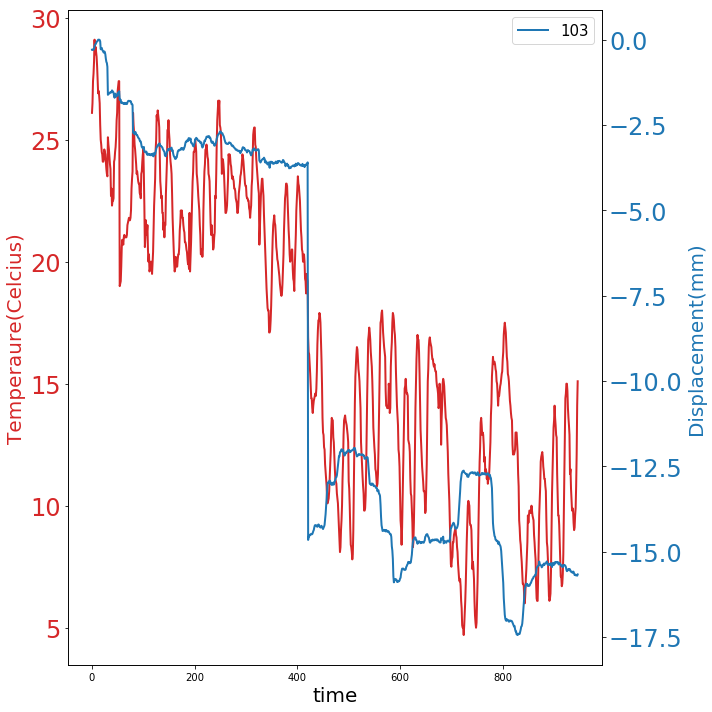

In [53]:
fig, ax1 = plt.subplots(figsize=(10, 10))
color = 'tab:red'
ax1.set_xlabel('time', fontsize = 20.0)
ax1.set_ylabel('Temperaure(Celcius)', color=color, fontsize = 20.0)
ax1.plot(op['t'].T, color=color, linewidth=2)
ax1.tick_params(axis='y', labelcolor=color, labelsize = 24)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Displacement(mm)', color=color, fontsize = 20.0)  # we already handled the x-label with ax1
ax2.plot(op['f'], linewidth=2)
ax2.tick_params(axis='y', labelcolor=color, labelsize = 24)
ax2.legend(DISP_SNS_FOR_APCA, fontsize=15)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

In [10]:
X1, PC, Q = run_apca_cas(op)

No handles with labels found to put in legend.


<function matplotlib.pyplot.show(*args, **kw)>

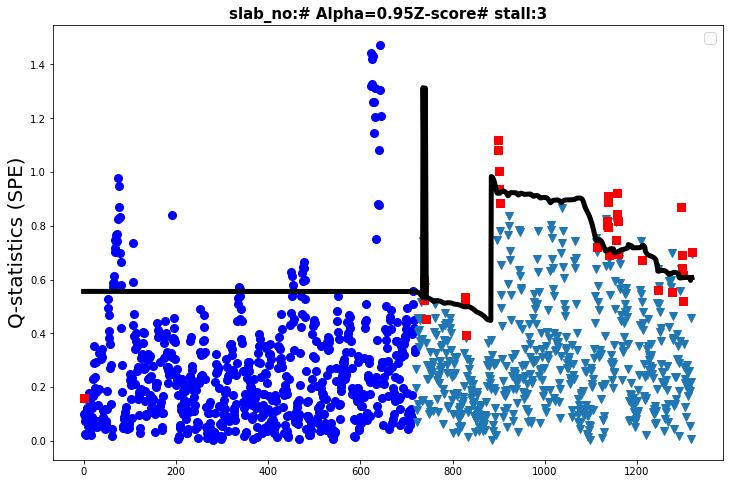

In [11]:
fig = plt.figure(figsize=(12, 8))

x0 = op['IND_x0']
x1 = op['IND_x1']
plt.plot(x0, Q['Qdist'][x0], 'bo', linewidth=2, markersize=8)
plt.plot(x1, Q['Qdist'][x1], 'v', linewidth=2, markersize=8)

alpha = 0.95
SD_type = 'Z-score'
PCA_par = {}
PCA_par['n_stall'] = 3;

IND_abnor = np.argwhere(PC['Updated']==0)
IND_nor = np.argwhere(PC['Updated']==1)
plt.plot(IND_abnor,Q['Qdist'][IND_abnor],'rs',linewidth=2, markersize=8) # Outlier and faulty samples
plt.plot(IND_nor,Q['distcrit'][IND_nor][:,:, 0],'k-',linewidth=5, markersize=8) # Outlier and faulty samples
plt.ylabel('Q-statistics (SPE)', fontsize=20)
plt.title('slab_no:' + '# Alpha='+str(alpha)+str(SD_type)+'# stall:'+str(PCA_par['n_stall']),fontsize=15,fontweight='bold')
plt.legend(fontsize='x-large')
plt.show

### Generate Anomalies in the given data

* anomal displacement 5mm occur
* anomal displacement 10mm occur 
* anomal displacement 20mm occur 

* anomally displacement went to zero

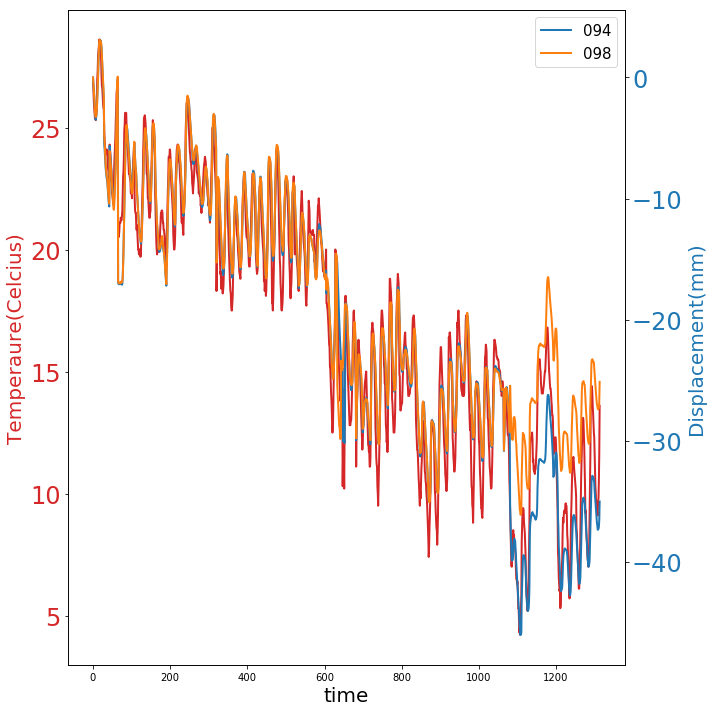

In [12]:
disp_sns_num = DISP_SNS_FOR_APCA
trainig_range = 24*30 # for one month 
tmp_sns_num = '095'
anomal_disp = 5
anomal_occur = 24*45

op = cvtDataForAPCA(sns_dict, disp_sns_num, trainig_range,
                   tmp_sns_num, anomal_occur = anomal_occur, anomal_disp = anomal_disp)

plotData(op, disp_sns_num)

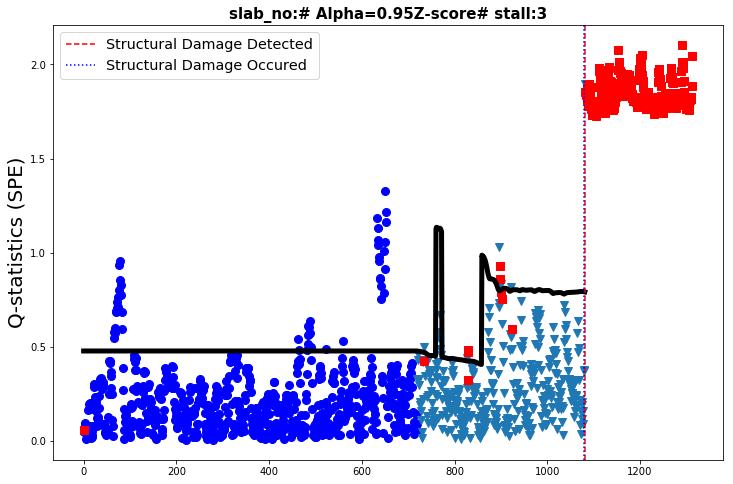

In [18]:
X1, PC, Q = run_apca_cas(op)
plotAPCA(op, X1, PC, Q, anomal_occur)

### Run circle detection for selected sensors and save the result images

In [14]:
snsForCD = ['008']


ANA_PERIOD = [20201115, 99999999] # analysis period
for sns_num in tqdm(snsForCD) :
    for date, time in sns_dict[sns_num]['data'].items():
        for time, dir_ in time.items():
            if (int(date) >= ANA_PERIOD[0]) and (int(date) <= ANA_PERIOD[1]):
                saveCDResult(dir_['Img'], DATASET_FOLDER, CD_PARAM_CONFIG)

100%|██████████| 1/1 [06:59<00:00, 419.10s/it]


In [ ]:

folder = '/media/sss/Seagate Backup Plus Drive/NIA_Smart_Monitoring/2020/data' 
imsave_folder = '/media/sss/Seagate Backup Plus Drive/NIA_Smart_Monitoring/2020/vnvdisp' 

sns_num = '212'


date = "20201028"
time = "010000"

date = "20201110"
time = "010000"

date = "20201110"
time = "150000"


img_name = 'Img_' + sns_num + '_' + date + '_' + time[:2] + '0100.jpg' 
img = cv2.imread(osp.join(folder, img_name))
cv2.imwrite(osp.join(imsave_folder, img_name), img)

# print('displacement is ' + str(np.round(sns_dict[sns_num]['data'][date][time]['x_disp'],1)) + 'mm' )

plt.imshow(img)